In [254]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

from mmit.core.solver import compute_optimal_costs

## Interval generation functions

In [241]:
def generate_intervals_full_random(n_intervals, mean_y=0., open_interval_proba=0.3):
    lower = np.random.rand(n_intervals)**2
    upper = lower + np.random.rand(n_intervals)**2
    
    # Randomly make some intervals open
    for idx in np.where(np.random.binomial(1, open_interval_proba, n_intervals) == 1)[0]:
        if np.random.binomial(1, 0.5) == 1:
            lower[idx] = -np.infty
        else:
            upper[idx] = np.infty
            
    return np.array(zip(lower, upper))

def generate_intervals_random_width(n_intervals, base_y=0., width_std=0., open_interval_proba=0.3):  
    lower = base_y - numpy.random.normal(loc=0., scale=width_std, size=n_intervals)
    upper = base_y + numpy.random.normal(loc=0., scale=width_std, size=n_intervals)
    
    # Randomly make some intervals open
    for idx in np.where(np.random.binomial(1, open_interval_proba, n_intervals) == 1)[0]:
        if np.random.binomial(1, 0.5) == 1:
            lower[idx] = -np.infty
        else:
            upper[idx] = np.infty
           
    return np.array(zip(lower, upper))

def generate_intervals_fixed_width(n_intervals, mean_y=0., std_y=0., interval_width=0.1, open_interval_proba=0.3):  
    interval_centers = numpy.random.normal(loc=mean_y, scale=std_y, size=n_intervals)
    lower = interval_centers - interval_width
    upper = interval_centers + interval_width
    
    # Randomly make some intervals open
    for idx in np.where(np.random.binomial(1, open_interval_proba, n_intervals) == 1)[0]:
        if np.random.binomial(1, 0.5) == 1:
            lower[idx] = -np.infty
        else:
            upper[idx] = np.infty
           
    return np.array(zip(lower, upper))

### Fixed-width interval generation

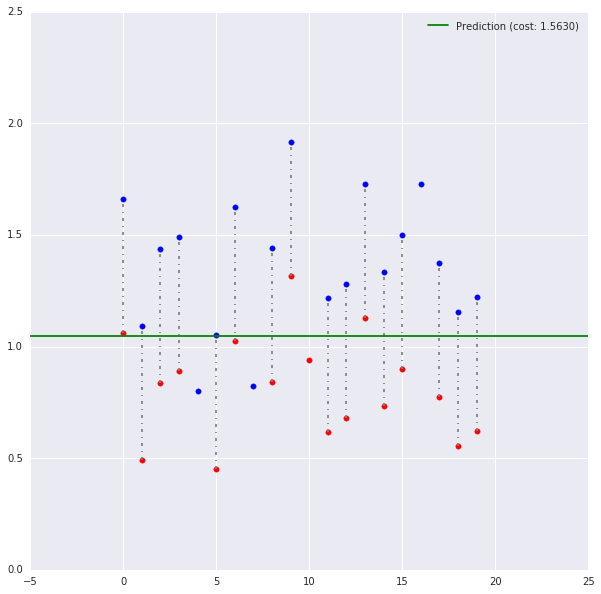

In [263]:
y = generate_intervals_fixed_width(n_intervals=20, mean_y=1., std_y=0.3, interval_width=0.3, open_interval_proba=0.31)

_, preds, costs = compute_optimal_costs(np.array(zip(*y)[0], dtype=np.double), np.array(zip(*y)[1], dtype=np.double), 
                                    0.1, 0)

plt.clf()
plt.scatter(np.arange(len(y)), zip(*y)[0], color="red", s=30)
plt.scatter(np.arange(len(y)), zip(*y)[1], color="blue", s=30)
plt.vlines(np.arange(len(y)), zip(*y)[0], zip(*y)[1], color="grey", linestyle="-.")
plt.axhline(preds[-1], color="green", label="Prediction (cost: {0:.4f})".format(costs[-1]))
plt.gcf().set_size_inches(10, 10)
plt.legend()
plt.show()

## Olympics datasets

In [247]:
def generate_dataset(n_examples = 2000, n_groups=5, linear=False, open_interval_proportion=0.1):
    n_ex_by_group = n_examples / n_groups
    
    X = None
    y = None
    
    cmap = ["#0000FF", "#FFFF00", "#000000", "#00FF00", "#FF0000"] + sns.color_palette("hls", 8)
    plt.clf()
    for i in xrange(n_groups):
        # Position of the group
        x1 = float(i)
        x2 = float((i + 1) % 2)
        
        # Generate the group's intervals
        if linear:
            mean_y = i
        else:
            mean_y = np.exp(i)
        group_y = generate_intervals_fixed_width(n_intervals=n_ex_by_group, 
                                                 mean_y=mean_y, 
                                                 std_y=0.3, 
                                                 interval_width=0.3, 
                                                 open_interval_proba=open_interval_proportion)
        group_X = np.random.multivariate_normal([x1, x2], [[0.08, 0.], [0., 0.08]], size=len(group_y))
        
        # Save the group X and y values
        if X is None:
            X = group_X
            y = group_y
        else:
            X = np.vstack((X, group_X))
            y = np.hstack((y, group_y))
        
        # Plot this group
        _, preds, costs = compute_optimal_costs(np.array(zip(*group_y)[0], dtype=np.double), 
                                                np.array(zip(*group_y)[1], dtype=np.double), 0., 0)
        plt.scatter(zip(*group_X)[0], zip(*group_X)[1], color=cmap[i % len(cmap)], label="{0:.4f}".format(preds[-1]))
    
    # Show the plot
    plt.gcf().set_size_inches(10, 10)
    plt.legend()
    plt.show()
    
    return X, y

### Olympics linear

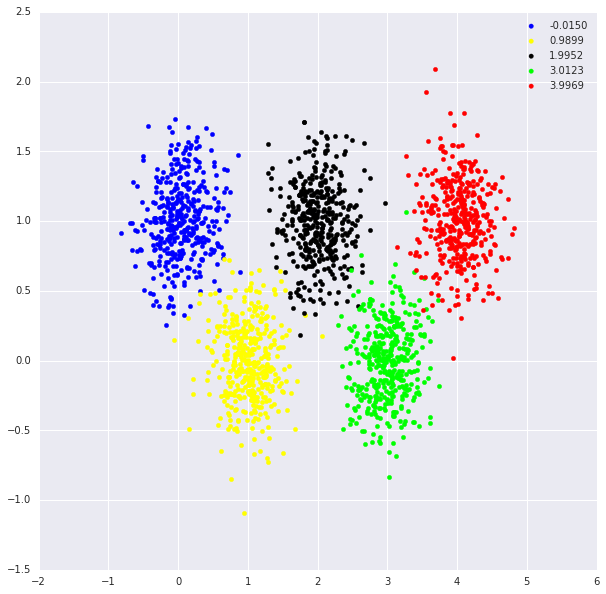

In [261]:
n_folds = 5
X, y = generate_dataset(n_groups=5, linear=True)
folds = np.arange(X.shape[0]) % n_folds + 1
np.random.shuffle(folds)

ds_dir = "data/olympics.linear"
if not os.path.exists(ds_dir):
    os.mkdir(ds_dir)
    
open(os.path.join(ds_dir, "features.csv"), "w").writelines(["x1, x2\n"] + 
                                                          ["{0:.6f}, {1:.6f}\n".format(xi[0], xi[1]) for xi in X])
open(os.path.join(ds_dir, "targets.csv"), "w").writelines(["min.log.penalty, max.log.penalty\n"] + 
                                                          ["{0:.6f}, {1:.6f}\n".format(yi[0], yi[1]) for yi in y])
open(os.path.join(ds_dir, "folds.csv"), "w").writelines(["folds\n"] + ["{0:d}\n".format(f) for f in folds])

### Olympics non-linear

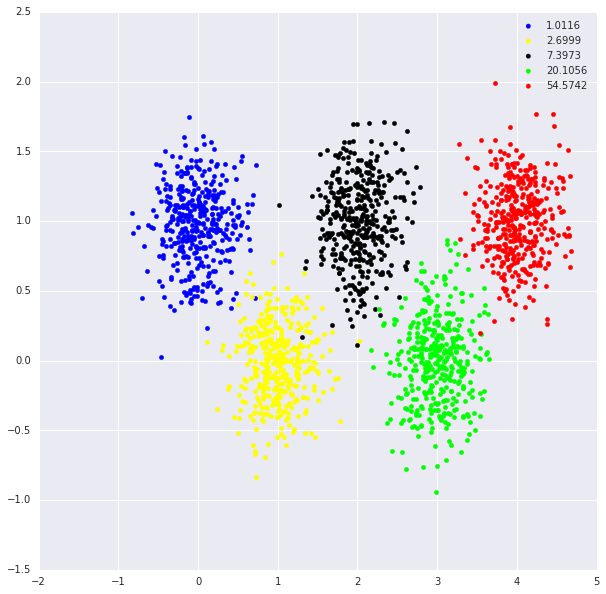

In [262]:
n_folds = 5
X, y = generate_dataset(n_groups=5, linear=False)
folds = np.arange(X.shape[0]) % n_folds + 1
np.random.shuffle(folds)

ds_dir = "data/olympics.nonlinear"
if not os.path.exists(ds_dir):
    os.mkdir(ds_dir)
    
open(os.path.join(ds_dir, "features.csv"), "w").writelines(["x1, x2\n"] + 
                                                          ["{0:.6f}, {1:.6f}\n".format(xi[0], xi[1]) for xi in X])
open(os.path.join(ds_dir, "targets.csv"), "w").writelines(["min.log.penalty, max.log.penalty\n"] + 
                                                          ["{0:.6f}, {1:.6f}\n".format(yi[0], yi[1]) for yi in y])
open(os.path.join(ds_dir, "folds.csv"), "w").writelines(["folds\n"] + ["{0:d}\n".format(f) for f in folds])